In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pickle


In [2]:
df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")
df_eddies.head()


,Day,ID,Cyc,Lon,Lat,ic,jc,x0,y0,q11,q12,q22,w,Age,fname
0,1462,1,CE,161.093546,-29.714998,261,275,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1463,1,CE,160.871720,-29.764770,258,273,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1464,1,CE,160.922307,-29.791470,259,272,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1465,1,CE,160.955011,-29.644446,259,276,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1466,1,CE,160.900960,-29.634113,258,276,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347,107,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [3]:
sample_eddies = [2749, 8, 2504, 896, 1394, 382, 1967, 926]
with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
    

In [4]:
eddy = 382

dic = dic_sample[f'Eddy{eddy}']
t0, t_r = 30, 5
days = list(dic.keys())[t0 - t_r : t0 + t_r + 1]

df_int = pd.concat([dic[day].assign(Day=int(day[3:])) for day in days], ignore_index=True)
df_int = df_int[df_int['Depth'] >= -1000]
df_int.head()


,x,y,Q,w,z,Depth,TD,Grad,Day
0,491.571462,492.083395,"[[-0.003969096910500763, 0.001562166203494834]...",-0.029639,0,-1.783320,0.000000,NaN,2698
1,490.174309,491.388898,"[[-0.003993579956302959, 0.0015182870080628302...",-0.029725,1,-5.879627,1.560244,0.497080,2698
2,489.622731,491.054422,"[[-0.003998716718951495, 0.001495514756028457]...",-0.029761,2,-10.725783,2.203710,0.606399,2698
3,489.307382,490.813176,"[[-0.0040024933744435415, 0.001473300402119757...",-0.029789,3,-16.383097,2.596057,0.765014,2698
4,489.127695,490.622722,"[[-0.004006593441129104, 0.0014491480279933452...",-0.029805,4,-22.925581,2.847027,1.059916,2698


### Clustering Technique

#### Solve the Problem

$$
\huge x' = x\cos\theta - y\sin\theta + a
$$
$$
\huge y' = x\sin\theta + y\cos\theta + b
$$
\
$$
\begin{aligned}
\huge R(a, b, \theta) & \huge = \sum_i \left[x_i'(t_1) - x_i(t_2)\right]^2 + \left[y_i'(t_1) - y_i(t_2)\right]^2 \\
                      & \huge = \sum_i \left[x_i(t_1)\cos\theta - y_i(t_1)\sin\theta + a - x_i(t_2) \right]^2 + \left[x_i(t_1)\sin\theta + y_i(t_1)\cos\theta + b - y_i(t_2)\right]^2
\end{aligned}
$$

In [5]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg) 
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))
    

In [6]:
def cost(p, x_t, y_t, x_ref, y_ref):
    dx, dy, θ = p
    c, s = np.cos(θ), np.sin(θ)
    tx =  x_t * c - y_t * s + dx
    ty =  x_t * s + y_t * c + dy
    return np.sum((tx - x_ref)**2 + (ty - y_ref)**2)

def rmse(p, x_t, y_t, x_ref, y_ref):
    return np.sqrt(cost(p, x_t, y_t, x_ref, y_ref) / len(x_ref))

def resample_coords(x, y, n):
    # cumulative distance along the curve
    d = np.hypot(np.diff(x), np.diff(y))
    s = np.concatenate([[0], np.cumsum(d)])
    fx = interp1d(s, x, kind='linear')
    fy = interp1d(s, y, kind='linear')
    s_new = np.linspace(0, s[-1], n)
    x2, y2 = fx(s_new), fy(s_new)
    return x2 - x2[0], y2 - y2[0]

days = df_int['Day'].unique()
mid_day = days[len(days)//2]
ref = df_int[df_int['Day'] == mid_day]
n_ref = len(ref)
x_ref, y_ref = resample_coords(ref.x.values, ref.y.values, n_ref)

results = []
for day in days:
    df_day = df_int[df_int['Day'] == day]
    x_t, y_t = resample_coords(df_day.x.values, df_day.y.values, n_ref)

    res = minimize(
        lambda p: cost(p, x_t, y_t, x_ref, y_ref),
        [0, 0, 0],
        bounds=[(None, None), (None, None), (0, 2*np.pi)]
    )
    if res.success:
        dx, dy, θ = res.x
        results.append({
            'Day':    day,
            'x_delta': dx,
            'y_delta': dy,
            'theta':   np.rad2deg(θ),
            'rmse':    rmse(res.x, x_t, y_t, x_ref, y_ref)
        })

df_best_shift = pd.DataFrame(results)
df_best_shift


,Day,x_delta,y_delta,theta,rmse
0,2698,-2.008689,2.408212,16.736123,2.645212
1,2699,-2.026173,1.401723,8.259736,2.407780
2,2700,-2.041580,2.271557,0.000000,2.301909
3,2701,-3.550352,1.955479,0.000000,2.784791
4,2702,-4.569365,-1.208302,0.000000,2.530834
5,2703,0.000000,0.000000,0.000000,0.000000
6,2704,-3.063211,-1.579007,13.033024,1.330256
7,2705,-0.841566,-1.865074,18.545076,1.494201
8,2706,1.752151,0.385009,12.149625,1.046073
9,2707,1.190608,2.329407,0.000000,1.950386


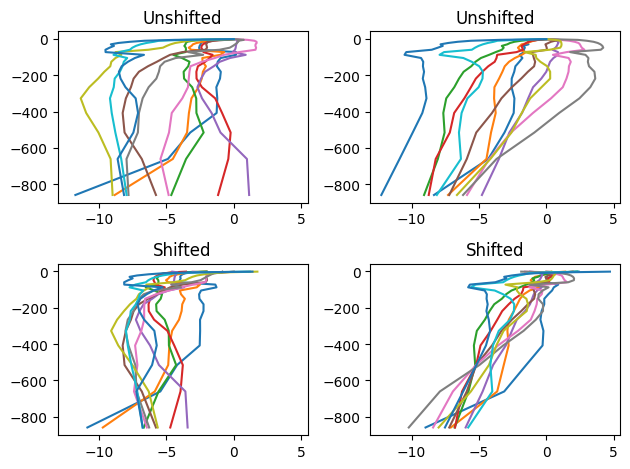

In [12]:
fig, axs = plt.subplots(2, 2)
for day in df_int['Day'].unique():
    df = df_int[df_int['Day']==day]
    x, y = df['x']-df.iloc[0]['x'], df['y']-df.iloc[0]['y']
    x, y = x.values, y.values
    axs[0,0].plot(x, df['Depth'])
    axs[0,1].plot(y, df['Depth'])
    axs[0,0].set_title('Unshifted')
    axs[0,1].set_title('Unshifted')
    data = df_best_shift[df_best_shift['Day']==day]
    x_delta, y_delta = data.iloc[0]['x_delta'], data.iloc[0]['y_delta']
    theta = data.iloc[0]['theta']

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + x_delta
    y_shifted = points_rotated[:, 1] + y_delta

    axs[1,0].plot(x_shifted, df['Depth'])
    axs[1,1].plot(y_shifted, df['Depth'])
    axs[1,0].set_title('Shifted')
    axs[1,1].set_title('Shifted')

xmin, xmax = 0, 0 
for ax in axs.flat:
    xmin = min(xmin, ax.get_xlim()[0])
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs.flat:
    ax.set_xlim(xmin, xmax)
plt.tight_layout()
plt.show()